# Generating Phantom

Here, **SpinWalk** generates phantoms containing cylinders with a radius of 20 µm. These cylinders will occupy 10% of the total volume, and the phantom will have a field of view (FoV) of 600 µm. The phantom will be stored in the `phantoms` folder.

In [1]:
%%bash
echo "Print help menu for phantom generation..."
spinwalk phantom -h

Print help menu for phantom generation...
Generate numerical phantom
Usage: spinwalk phantom [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -c,--cylinder                         Fill phantom with cylinders
  -s,--sphere                           Fill phantom with spheres
  -t,--two_pools                        Phantom with two pools each occupying half of the volume
  -p,--ply                              Convert triangular mesh from ply file
  -r,--radius FLOAT [50]                Radius of the cylinders/spheres in µm (negative value = random but smaller than radius)
  -n,--orientation FLOAT [90]           Orientation of the cylinders in degree with respect to B0
  -v,--volume_fraction FLOAT [4]        Fraction of shapes volume to FoV volume in % <0.0 100.0>
  -f,--fov FLOAT:POSITIVE               Voxel field of view in µm (isotropic)
  -z,--resolution UINT:POSITIVE         Base resolution
  -d,--dchi FLOAT [1.1e-07]             Suscepti

In [2]:
%%bash
# Define the output directory
output_dir="./phantoms"
mkdir -p "$output_dir"

vol_frac=5
resolution=600
fov=600
radius=5

# Define the output file
file_phantom="${output_dir}/r${radius}_vf${vol_frac}_fov${fov}_res${resolution}.h5"
# Call the command with the variable parameter and redirect the output
spinwalk phantom -c -r "$radius" -v "$vol_frac" -f "$fov" -z "$resolution" -y 0 -n 90 -e 0 -o "$file_phantom"

# check phantoms are there
echo -e "\nList of existing phantoms in phantom folder..."
ls -l --block-size=M ./phantoms


 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.20.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/log_spinwalk.txt"
Generating cylinder phantom...


Generating (1/2) 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100/100 
Generating (2/2) 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237/237 
Done.

List of existing phantoms in phantom folder...
total 2060M
-rw-r--r-- 1 aaghaeifar kyb 1030M Apr 27 19:49 r10_vf10_fov600_res600.h5
-rw-r--r-- 1 aaghaeifar kyb 1030M Apr 27 20:20 r5_vf5_fov600_res600.h5


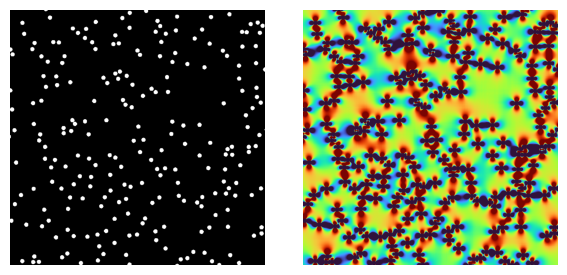

In [3]:
# plot the generated phantoms
import h5py
import matplotlib.pyplot as plt

def plot_phantom(file_path, title=None):
    with h5py.File(file_path, "r") as f:
        mask = f["mask"][()]
        fieldmap = f["fieldmap"][()]
        sz = tuple(dim // 2 for dim in mask.shape)
        # print orthogonal views
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].imshow(mask[:, :, sz[2]], cmap="gray")
        axes[0].axis("off")
        axes[1].imshow(fieldmap[:, :, sz[2]], cmap="turbo", vmin=-8e-8, vmax=8e-8)
        axes[1].axis("off")
        # title
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

# show the phantom
file_phantom  = "./phantoms/r5_vf5_fov600_res600.h5"
plot_phantom(file_phantom)


# Creating Configuration File

In [4]:
%%bash
# help menu for generating config file
spinwalk config -h

Generate configuration file
Usage: spinwalk config [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -s,--seq_name TEXT                    Sequence name: GRE, SE, and bSSFP
  -p,--phantoms TEXT ...                Path to phantom files as many as you want. e.g. -p phantom1.h5 phantom2.h5 ... phantomN.h5
  -e,--TE UINT:POSITIVE                 Echo time in µs
  -t,--timestep UINT:POSITIVE           timestep in µs
  -o,--output TEXT                      Path to save the configuration file


## bSSFP configuration file

In [5]:
%%bash
# Generating configuration files for the GRE sequence. Two files will be created: the first is the default config file containing all parameters, and the second is the GRE config file that includes the necessary changes to modify the default configuration.
spinwalk config -s bssfp --TE 2000 -t 50 -p ./phantoms/r5_vf5_fov600_res600.h5 -o ./bssfp.ini

# replace the default config file with the scales.ini as the parent config
sed -i 's/T1\[0\] = 2200/T1\[0\] = 1000/g' ./default_config.ini
sed -i 's/T1\[1\] = 2200/T1\[1\] = 1000/g' ./default_config.ini
sed -i 's/T2\[0\] = 41/T2\[0\] = 75/g' ./default_config.ini
sed -i 's/T2\[1\] = 41/T2\[1\] = 75/g' ./default_config.ini
sed -i 's/PHASE_CYCLING = 180/PHASE_CYCLING = 1/g' bssfp.ini

echo "" >> bssfp.ini
echo "" >> bssfp.ini
echo "[SIMULATION_PARAMETERS]" >> bssfp.ini
echo "B0 = 3" >> bssfp.ini
echo "WHAT_TO_SCALE = 2" >> ./bssfp.ini
for i in {0..36}; do
    value=$((i * 10 ))
    echo "SCALE[$i] = $value" >> ./bssfp.ini
done

# show content
echo -e "\n\nConfig file for bssfp:"
cat bssfp.ini


 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.20.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/log_spinwalk.txt"
Configuration file is generated in /DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/bssfp.ini


Config file for bssfp:
[GENERAL]
SEQ_NAME = bssfp
PARENT_CONFIG = /DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/default_config.ini

[FILES]
PHANTOM[0] = ./phantoms/r5_vf5_fov600_res600.h5

[SCAN_PARAMETERS]
TR = 4000
TE = 2000
RF_FA = 16.0
RF_PH = 0
RF_T = 0
TIME_STEP = 50
DUMMY_SCAN = -1
PHASE_CYCLING = 1

[SIMULATION_PARAMETERS]
B0 = 3
WHAT_TO_SCALE = 2


# Simulation

SpinWalk will read all the provided config files and simulate them sequentially.

In [6]:
%%bash
spinwalk sim -c bssfp.ini

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.20.0
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/log_spinwalk.txt"
<bssfp.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37/37 
Simulation completed successfully. See the log file


In [7]:
%%bash
# cat spinwalk_0.log
ls ./outputs

bssfp_r5_vf5_fov600_res600.h5


In [8]:
import os
import numpy as np
import h5py

tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined

results_dir = './outputs/'

def read_results(filename):
    signal_magnitude = []
    filepath = os.path.join(results_dir, filename)
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])
        S = np.array(h5['scales'])
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type)
            M_f = M[ids, mask, 0, :]
            M_f = np.mean(M_f[...,0:2], axis=0)
            signal_magnitude.append(np.linalg.norm(M_f))
    return signal_magnitude


############
filename = 'bssfp_r5_vf5_fov600_res600.h5'
signal_magnitude = np.array(read_results(filename))
print(signal_magnitude.shape)

with h5py.File(os.path.join(results_dir, filename), 'r') as h5:
    scales = np.array(h5['scales'])

print(scales.squeeze())

(37,)
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360.]


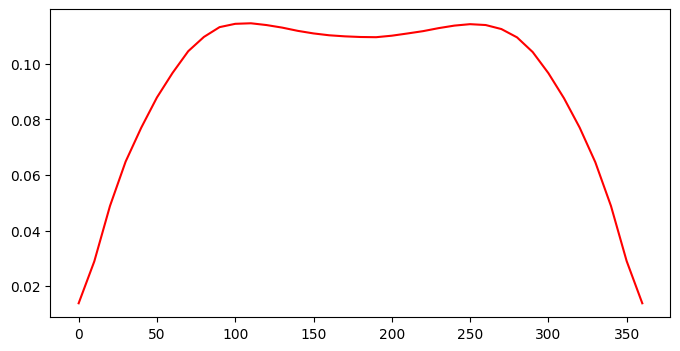

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(scales.squeeze(), signal_magnitude, 'r-')
